In [1]:
import os
os.chdir('..')
from master import *

In [2]:
from function import *

In [3]:
df = pd.read_csv("../data/creditcard.csv")

In [4]:
%%time
master( df, method= 'random', shrink= 10 )

ElasticNet begin
RandomForest begin
Xgboost begin
ElasticNet metrics


NameError: name 'plot_confusion_matrix' is not defined

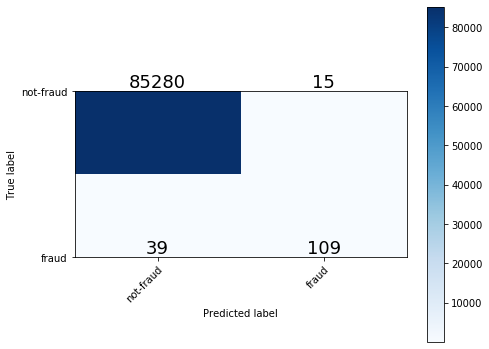

In [8]:
test_confusion_matrix(y_test, y_pred, ["not-fraud", "fraud"])

# Model and evaluation

In [6]:
X_train, X_test, y_train, y_test = function.getdataset(df)

In [7]:
y_pred = xgboost_model(X_train, y_train, X_test)

# Over-sample

In [ ]:
%%time
X_train, y_train = function.smote_svm(X_train, y_train)